In [ ]:
import numpy as np
import os
import glob
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import ExtraTreesRegressor
! pip install tensorflow_addons
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
def feed_forward(num_units):
  # learning rate
  lr = 1e-3

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=num_units, activation=tf.keras.activations.relu))
  model.add(tf.keras.layers.Dense(units = 1))

  metrics = [tf.keras.metrics.MeanAbsoluteError()]

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                loss='mse',
                metrics=metrics)
  
  return model

In [ ]:
nonLinCFA_features_folder = "./new_features/"
csv_target = "./csv/Emiliani2.csv"

In [ ]:
# take target values ultil the last useful date (cutting off 2020-2022)
from datetime import datetime

END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')
target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})
target['date'] = pd.to_datetime(target['date'],format = '%Y-%m-%d')

# remove dates not available in features
target = target[target['date'] <= END_DATE]
target_df = target['mean'].to_frame()

In [ ]:
# divide target into train/val/test sets

scaler_t = StandardScaler()

TRAIN_END_DATE = datetime.strptime('2009-12-31', '%Y-%m-%d')
VALID_END_DATE = datetime.strptime('2014-12-31', '%Y-%m-%d')
TEST_END_DATE = datetime.strptime('2019-12-31', '%Y-%m-%d')

train_perc=0.475 # training data from 2001-01 to 2009-12 included, 411 samples
valid_perc = 0.2625 # 228 samples for valid and test sets
tot_rows = len(target_df)

target_train = target[target['date'] <= TRAIN_END_DATE]['mean'].to_frame()
# fit the scalers on training data
scaler_t.fit(target_train)
# scale all the dataset
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

target_train = target_df.iloc[0:round(tot_rows*train_perc)-1,:]
target_validation = target_df.iloc[round(tot_rows*train_perc)-1:round(tot_rows*(valid_perc+train_perc))]
target_test = target_df.iloc[round(tot_rows*(valid_perc+train_perc)):round(tot_rows*(valid_perc*2+train_perc))]

In [ ]:
csv_features = glob.glob(nonLinCFA_features_folder+'*.csv')
csv_features

['./new_features/Adda_nonLinCFA_wrapper_best5_train.csv',
 './new_features/Piemonte_Nord_nonLinCFA_CMI_test.csv',
 './new_features/Dora_nonLinCFA_CMI_val.csv',
 './new_features/Ticino_nonLinCFA_CMI_train.csv',
 './new_features/Piemonte_Sud_nonLinCFA_wrapper_best5_test.csv',
 './new_features/Emiliani1_nonLinCFA_CMI_test.csv',
 './new_features/Emiliani1_nonLinCFA_wrapper_best5_val.csv',
 './new_features/Lambro_Olona_nonLinCFA_CMI_train.csv',
 './new_features/Piemonte_Sud_nonLinCFA_wrapper_best5_val.csv',
 './new_features/Dora_nonLinCFA_CMI_train.csv',
 './new_features/Oglio_Iseo_nonLinCFA_CMI_train.csv',
 './new_features/Piemonte_Nord_nonLinCFA_best5_CMI_train.csv',
 './new_features/Oglio_Iseo_nonLinCFA_best5_CMI_train.csv',
 './new_features/Emiliani1_nonLinCFA_wrapper_best5_train.csv',
 './new_features/Lambro_Olona_nonLinCFA_CMI_val.csv',
 './new_features/Dora_nonLinCFA_wrapper_best5_train.csv',
 './new_features/Dora_nonLinCFA_wrapper_best5_val.csv',
 './new_features/Ticino_nonLinCFA_wr

## NonLinCFA CMI best 5

In [ ]:
csv_path = nonLinCFA_features_folder + "Emiliani2_nonLinCFA_best5_CMI_"

In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()

features_train = pd.read_csv(csv_path + 'train.csv')
scaler_f.fit(features_train)

features_valid = pd.read_csv(csv_path + 'val.csv')
features_test = pd.read_csv(csv_path + 'test.csv')
features_valid[features_valid.columns] = scaler_f.transform(features_valid[features_valid.columns])
features_test[features_test.columns] = scaler_f.transform(features_test[features_test.columns])

features_train_validation = pd.concat([features_train, features_valid])

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_tg_1w_4
1: cyclostationary_mean_rr_4w_3
2: cyclostationary_mean_tg_4
3: cyclostationary_mean_rr_8w_0
4: cyclostationary_mean_rr_12w_1


In [ ]:
X_train = features_train.values
X_validation = features_valid.values
X_train_validation = features_train_validation.values
X_test = features_test.values

In [ ]:
y_train = target_train.values.ravel()
y_valid = target_validation.values.ravel()
y_test = target_test.values.ravel()
y_train_valid = pd.concat([target_train, target_validation]).values.ravel()

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

reg = LinearRegression().fit(X_train_validation, y_train_valid)
print("Linear Regression : ")
print("R2_train: ", round(reg.score(X_train_validation, y_train_valid),3))
print("R2_test: ", round(reg.score(X_test, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test)),3))
print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test),squared=False),3))

Linear Regression : 
R2_train:  0.235
R2_test:  0.23
MAE:  0.579
MSE:  0.728


### FFNN

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(4)

history = ffnn_val.fit(X_train, y_train, shuffle=False, epochs=1000, 
                        validation_data=(X_validation, y_valid), verbose = 0)

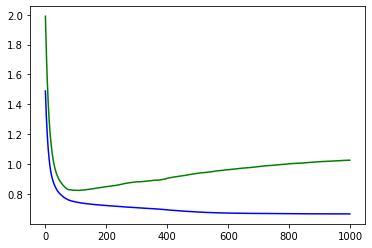

In [ ]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [ ]:
ffnn = feed_forward(4)
ffnn.fit(X_train_validation, y_train_valid, shuffle=False, epochs=100, verbose = 0)


ffnn_MAE = mean_absolute_error(y_test, ffnn.predict(X_test))
ffnn_MSE = mean_squared_error(y_test, ffnn.predict(X_test))

metric = RSquare()
metric.update_state(y_test, ffnn.predict(X_test).ravel())
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(y_train_valid, ffnn.predict(X_train_validation).ravel())
r2_train = metric.result()
r2_train.numpy()
print (" FFNN:")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n",
      "R2_test: ",round(r2_test.numpy(),3), "\n", "R2_train: ", round(r2_train.numpy(),3))

20/20 [==============================] - 0s 1ms/step
 FFNN:
 MAE:  0.582 
 MSE:  0.516 
 R2_test:  0.251 
 R2_train:  0.206


## NonLinCFA CMI all

In [ ]:
csv_path = nonLinCFA_features_folder + "Emiliani2_nonLinCFA_CMI_"

In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()

features_train = pd.read_csv(csv_path + 'train.csv')
scaler_f.fit(features_train)

features_valid = pd.read_csv(csv_path + 'val.csv')
features_test = pd.read_csv(csv_path + 'test.csv')
features_valid[features_valid.columns] = scaler_f.transform(features_valid[features_valid.columns])
features_test[features_test.columns] = scaler_f.transform(features_test[features_test.columns])

features_train_validation = pd.concat([features_train, features_valid])

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_tg_1w_4
1: cyclostationary_mean_rr_4w_3
2: cyclostationary_mean_tg_4
3: cyclostationary_mean_rr_8w_0
4: cyclostationary_mean_rr_12w_1
5: cyclostationary_mean_tg_8w_3
6: cyclostationary_mean_rr_16w_2
7: cyclostationary_mean_rr_8w_2
8: cyclostationary_mean_tg_8w_0
9: cyclostationary_mean_rr_16w_1
10: cyclostationary_mean_tg_1w_3
11: cyclostationary_mean_rr_12w_0


In [ ]:
X_train = features_train.values
X_validation = features_valid.values
X_train_validation = features_train_validation.values
X_test = features_test.values

In [ ]:
y_train = target_train.values.ravel()
y_valid = target_validation.values.ravel()
y_test = target_test.values.ravel()
y_train_valid = pd.concat([target_train, target_validation]).values.ravel()

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

reg = LinearRegression().fit(X_train_validation, y_train_valid)
print("Linear Regression : ")
print("R2_train: ", round(reg.score(X_train_validation, y_train_valid),3))
print("R2_test: ", round(reg.score(X_test, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test)),3))
print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test),squared=False),3))

Linear Regression : 
R2_train:  0.29
R2_test:  0.325
MAE:  0.541
MSE:  0.682


### FFNN

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(4)

history = ffnn_val.fit(X_train, y_train, shuffle=False, epochs=1000, 
                        validation_data=(X_validation, y_valid), verbose = 0)

Text(0, 0.5, 'loss')

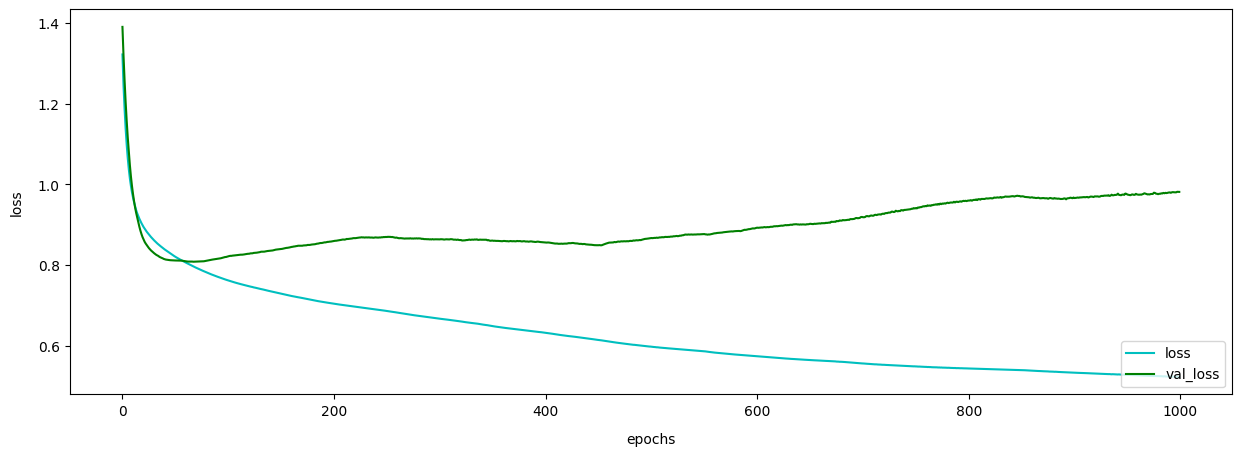

In [ ]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [ ]:
ffnn = feed_forward(4)
ffnn.fit(X_train_validation, y_train_valid, shuffle=False, epochs=220, verbose = 0)


ffnn_MAE = mean_absolute_error(y_test, ffnn.predict(X_test))
ffnn_MSE = mean_squared_error(y_test, ffnn.predict(X_test))

metric = RSquare()
metric.update_state(y_test, ffnn.predict(X_test).ravel())
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(y_train_valid, ffnn.predict(X_train_validation).ravel())
r2_train = metric.result()
r2_train.numpy()
print (" FFNN:")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n",
      "R2_test: ",round(r2_test.numpy(),3), "\n", "R2_train: ", round(r2_train.numpy(),3))

20/20 [==============================] - 0s 1ms/step
 FFNN:
 MAE:  0.531 
 MSE:  0.45 
 R2_test:  0.346 
 R2_train:  0.274


## NonLinCFA wrapper best 5

In [ ]:
csv_path = nonLinCFA_features_folder + "Emiliani2_nonLinCFA_wrapper_best5_"

In [ ]:
# extract features train/val/test sets

scaler_f = StandardScaler()

features_train = pd.read_csv(csv_path + 'train.csv')
scaler_f.fit(features_train)

features_valid = pd.read_csv(csv_path + 'val.csv')
features_test = pd.read_csv(csv_path + 'test.csv')
features_valid[features_valid.columns] = scaler_f.transform(features_valid[features_valid.columns])
features_test[features_test.columns] = scaler_f.transform(features_test[features_test.columns])

features_train_validation = pd.concat([features_train, features_valid])

In [ ]:
idx_dic = {}
for col in features_train.columns:
    idx_dic[col] = features_train.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_tg_1w_5
1: cyclostationary_mean_rr_8w_3
2: cyclostationary_mean_tg_8w_1
3: cyclostationary_mean_rr_16w_2
4: cyclostationary_mean_tg_1w_6


In [ ]:
X_train = features_train.values
X_validation = features_valid.values
X_train_validation = features_train_validation.values
X_test = features_test.values

In [ ]:
y_train = target_train.values.ravel()
y_valid = target_validation.values.ravel()
y_test = target_test.values.ravel()
y_train_valid = pd.concat([target_train, target_validation]).values.ravel()

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

reg = LinearRegression().fit(X_train_validation, y_train_valid)
print("Linear Regression : ")
print("R2_train: ", round(reg.score(X_train_validation, y_train_valid),3))
print("R2_test: ", round(reg.score(X_test, y_test),3))
print("MAE: ", round(mean_absolute_error(y_test,reg.predict(X_test)),3))
print("MSE: ", round(mean_squared_error(y_test,reg.predict(X_test),squared=False),3))

Linear Regression : 
R2_train:  0.267
R2_test:  0.282
MAE:  0.558
MSE:  0.703


### FFNN

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

ffnn_val = feed_forward(4)

history = ffnn_val.fit(X_train, y_train, shuffle=False, epochs=1000, 
                        validation_data=(X_validation, y_valid), verbose = 0)

Text(0, 0.5, 'loss')

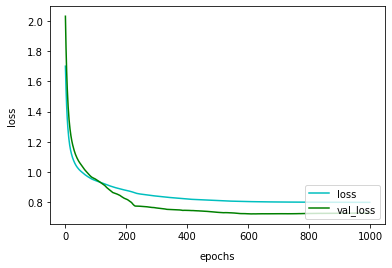

In [ ]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")
plt.style.use('default')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15,5)

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [ ]:
ffnn = feed_forward(4)
ffnn.fit(X_train_validation, y_train_valid, shuffle=False, epochs=200, verbose = 0)

ffnn_MAE = mean_absolute_error(y_test, ffnn.predict(X_test))
ffnn_MSE = mean_squared_error(y_test, ffnn.predict(X_test))

metric = RSquare()
metric.update_state(y_test, ffnn.predict(X_test).ravel())
r2_test = metric.result()
r2_test.numpy()

metric = RSquare()
metric.update_state(y_train_valid, ffnn.predict(X_train_validation).ravel())
r2_train = metric.result()
r2_train.numpy()
print (" FFNN:")
print(" MAE: ", round(ffnn_MAE,3), "\n", "MSE: ", round(ffnn_MSE,3), "\n",
      "R2_test: ",round(r2_test.numpy(),3), "\n", "R2_train: ", round(r2_train.numpy(),3))

20/20 [==============================] - 0s 1ms/step
 FFNN:
 MAE:  0.556 
 MSE:  0.489 
 R2_test:  0.289 
 R2_train:  0.255
